# Train a simple deep CNN on the CIFAR10 small images dataset.

KerasのSequential Modelを利用して複数層を追加している。最終的に出力する分類数(Class数)は前述の通り10個、Data AugmentationをTrueにしているので画像あえて加工したものを水増ししてCNNの入力とし、Modelのロバスト性を高める目的でflagが設定されている。(もちろんFalseで実行することもできる。) 

batch_sizeの指定はミニバッチとして1度に取り組むデータ(画像)の数であり、全てのClassからbatch_size分のデータをランダムで取得する。1epochとはバッチサイズで指定したサンプルデータを全て使用した状態を示す。よって今回のTrainingで利用する画像数は50000枚、それを32のバッチサイズで画像数を定義するので、50000 / 32 = 1563 1563回のバッチを実施する。1バッチでパラメータを更新するので、1563回の更新が1epoch内で繰り返される。epochsで指定されている100回は1epochを100回実行すること。まとめると以下のようになる。

- batch_size : Datasetの中で何個のDataをサンプルして1回のバッチで利用するかを定義する。
- steps_per_epoch : 1epoch内において何回バッチにてパラメータを更新するかを定義する。
- 1epoch : batch_sizeをsteps_per_epoch回繰り返して全てのDatasetを参照した状態を1epochとする。
 

In [12]:
'''Train a simple deep CNN on the CIFAR10 small images dataset.
It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).
'''

from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [10]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


# model

In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        18496     
__________

Sequential Modelのaddを利用して層を追加。例えば下記は2次元の畳み込みレイヤーを追加している。Conv2Dの最初の引数は畳み込みにおける出力フィルタの数、第二引数は3x3の畳み込み処理を適用することを意味する。input_shapeについては今回1画像のサイズが32x32、RGBなので3層あるということで、x_train.shape[1:]の値は(32, 32, 3)となっている。Sequential Modelの最初の層にはinput_shapeの情報が必ず必要。 

model.summary()で各LayerとOutput Shape、Paramを確認することができる。ネットワークの構成としては次のもの。

INPUT => CONV * 2 => POOL => CONV *2 => POOL => DENSE * 2 => OUTPUT。CNNの基本は畳み込み層とプーリング層で構成される。間に活性化関数を挟んでいるが、層としては取り扱わない(実際にはCONV層の活性化を図っている)。

- CONV : 畳み込み層。フィルタの大きさを指定し、入力データの特徴マップを作成するために各フィルタでの畳込みの結果を出力する。
- RELU : ここではCONVの出力に対して活性化関数(ランプ関数)を適用。
- POOL : プーリング演算を適用。CONV層の後に適用され、画像データ等の入力データを扱いやすくするために重要な情報は残しながら圧縮するDown Samplingを行う。
- DENSE : 全結合層。出力層の手前で実行され、出力はClassに分類される確率といった重みになる。 出力層の数は判別したいClass数に一致する必要がある。
 

Modelの学習にはcompileメソッドを利用する。loss関数として交差エントロピー、最適化手法としてRMSprop、評価指標としてはaccuracyを出力する。学習済みモデルと重みは指定したファイルに出力することができる。100epoch回した結果としての最終Accuracyは73.4%ということが分かる。

In [9]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,                        
                                     batch_size=batch_size),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using real-time data augmentation.
Epoch 1/100
1135/1563 [====================>.........] - ETA: 10:24 - loss: 2.3027 - acc: 0.0997

KeyboardInterrupt: 

50000


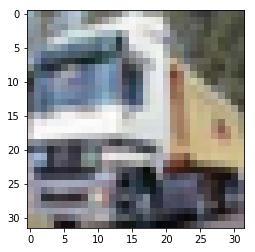

50000


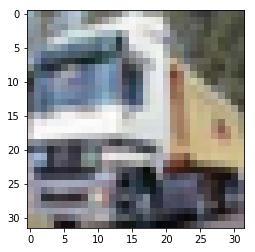

(<matplotlib.image.AxesImage at 0x1ae0ba9a2b0>, None)

In [18]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.3,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.3,
    shear_range=0.,  # set range for random shear
    zoom_range=0.,  # set range for random zoom
    channel_shift_range=0.,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied)
print(len(x_train))
plt.imshow(x_train[1]), plt.show()
datagen.fit(x_train)

print(len(x_train))
plt.imshow(x_train[1]), plt.show()


In [19]:
from keras.utils import plot_model
plot_model(model, 'model.png')

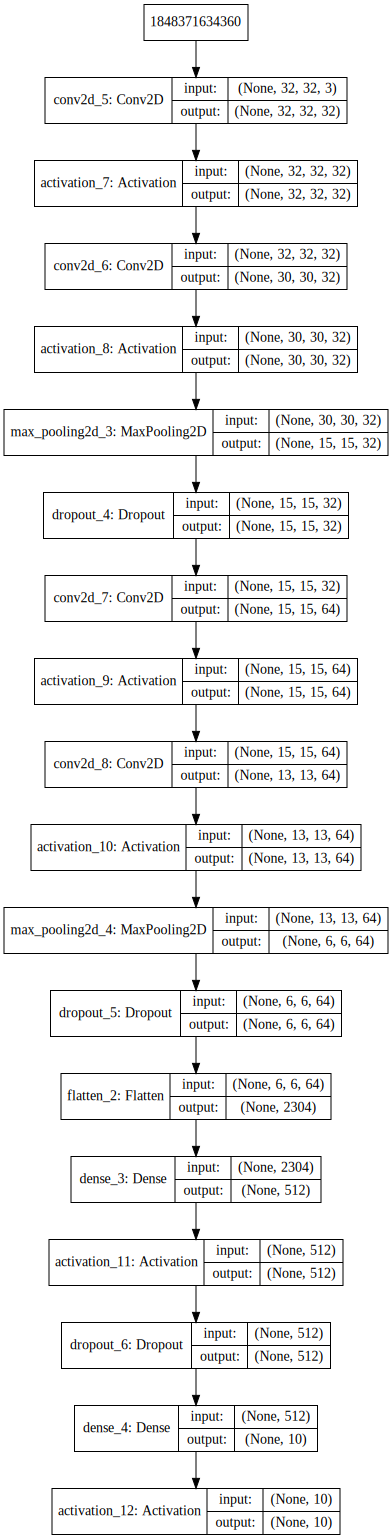

In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
datagen = ImageDataGenerator(
           rotation_range=45, # 画像をランダムに回転する回転範囲（0-180）
           width_shift_range=0.2, # ランダムに水平シフトする範囲
           height_shift_range=0.2, # ランダムに垂直シフトする範囲
           shear_range=0.2, # シアー強度（反時計回りのシアー角度（ラジアン））
           zoom_range=0.2, # ランダムにズームする範囲
           channel_shift_range=100.0,
           horizontal_flip=True, # 水平方向に入力をランダムに反転
           vertical_flip=True, # 垂直方向に入力をランダムに反転
           zca_whitening=True)